<a href="https://colab.research.google.com/github/whyd-nrzlvn/banana_classification/blob/main/models/Copy_of_Original__ES__InceptionV3_Classification_Cavendish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bagian Baru

## Import Dataset

In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Packages



In [ ]:
# import packages
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping

## Generate Dataset


In [ ]:
# menentukan direktori dataset training dan validation
train_dir = '/content/drive/MyDrive/Skripsi/DataPisang(1)/DataTraining'
valid_dir = '/content/drive/MyDrive/Skripsi/DataPisang(1)/DataTesting'

# menentukan ukuran gambar
img_width, img_height, channel = (299, 299, 3)

# **Melakukan Data Generator**

**Data Generator pada train dataset**

In [ ]:
# melakukan Data Generator pada train dataset
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 800 images belonging to 3 classes.


**Menyimpan Hasil Data Generator**

In [ ]:
from PIL import Image #nb
import os
import shutil

#Menyimpan gambar ke Google Drive
def save_to_drive(image_path, folder_path):
    # Copy gambar ke Google Drive
    shutil.copy(image_path, folder_path)

#Menyimpan 60 gambar hasil dari valid_data ke Google Drive, bisa di atur sesuai keinginan
i = 0
for batch, labels in train_data:
    images_per_class = {}  # Dictionary untuk melacak jumlah gambar yang disimpan dalam setiap kelas

    for idx, (img, label) in enumerate(zip(batch, labels)):
        if i >= 60:  # Menyimpan hanya 60 gambar
            break  # Berhenti jika sudah menyimpan sebanyak yang diinginkan

        # Mendapatkan label kelas
        class_index = label.argmax()

        # Membuat nama folder berdasarkan label kelas
        folder_name = f'{class_index}'

        # Path folder sesuai dengan kelas
        folder_path = os.path.join('/content/drive/MyDrive/Skripsi/dataImage', folder_name)

        # Jika folder belum ada, buat folder baru
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Nama file untuk disimpan secara sementara
        image_path = f'/content/augmented_image_{i}.jpg'

        # Simpan gambar dalam format JPEG
        Image.fromarray((img * 255).astype(np.uint8)).save(image_path)

        # Menyimpan gambar ke folder yang sesuai dengan kelasnya
        save_to_drive(image_path, folder_path)

        # Menambahkan jumlah gambar yang disimpan dalam kelas ini
        images_per_class[class_index] = images_per_class.get(class_index, 0) + 1

        i += 1

    # Memeriksa apakah setiap folder kelas berisi tepat 20 gambar
    if all(images == 20 for images in images_per_class.values()):
        break  # Berhenti jika setiap folder kelas sudah berisi 20 gambar


**Data Generator pada validation dataset**

In [ ]:
# melakukan Data Generator pada validation dataset
valid_datagen = ImageDataGenerator(
    rescale = 1./255
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (img_width, img_height),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 200 images belonging to 3 classes.


In [ ]:
classes = train_data.class_indices
classes

{'busuk': 0, 'masak': 1, 'mentah': 2}

**Membuat Model**

In [ ]:
from tensorflow.keras.applications import DenseNet201, MobileNet, InceptionV3

base_model = InceptionV3(
    input_shape=(img_width, img_height, 3),
    include_top=True,
    weights='imagenet'
)

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

96112376/96112376 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

**Modifikasi Pre trained model**

In [ ]:
x = base_model.layers[-2].output
output = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

## Compile Model

In [ ]:
# membuat compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics= [Recall(), Precision(), "accuracy"]
)

## Membuat Callback

In [ ]:
# membuat callback
model_callback = EarlyStopping(
    monitor = 'accuracy',
    verbose = 1,
    mode = 'max',
    patience = 10
)

## Membuat Fit Model

In [ ]:
# membuat fit model
history = model.fit(
    train_data,
    validation_data = valid_data,
    epochs = 50,
    steps_per_epoch = 25,
    callbacks = [model_callback],
    verbose = 1
)

Epoch 1/50
25/25 [==============================] - 631s 24s/step - loss: 0.7569 - recall: 0.4913 - precision: 0.7185 - accuracy: 0.6413 - val_loss: 0.6259 - val_recall: 0.6700 - val_precision: 0.7791 - val_accuracy: 0.7400
Epoch 2/50
25/25 [==============================] - 344s 14s/step - loss: 0.5792 - recall: 0.6825 - precision: 0.7679 - accuracy: 0.7337 - val_loss: 0.5413 - val_recall: 0.6800 - val_precision: 0.8000 - val_accuracy: 0.7500
Epoch 3/50
25/25 [==============================] - 329s 13s/step - loss: 0.5033 - recall: 0.7312 - precision: 0.8369 - accuracy: 0.8000 - val_loss: 0.4849 - val_recall: 0.7400 - val_precision: 0.8315 - val_accuracy: 0.7900
Epoch 4/50
25/25 [==============================] - 360s 14s/step - loss: 0.4681 - recall: 0.7650 - precision: 0.8488 - accuracy: 0.8163 - val_loss: 0.4609 - val_recall: 0.7350 - val_precision: 0.8448 - val_accuracy: 0.8100
Epoch 5/50
25/25 [==============================] - 328s 13s/step - loss: 0.4391 - recall: 0.7638 - prec

## Evaluasi

In [ ]:
# evaluasi hasil model kalian disini
model.evaluate(valid_data)

7/7 [==============================] - 59s 8s/step - loss: 0.2552 - recall: 0.9150 - precision: 0.9385 - accuracy: 0.9300


[0.2551778554916382,
 0.9150000214576721,
 0.9384615421295166,
 0.9300000071525574]

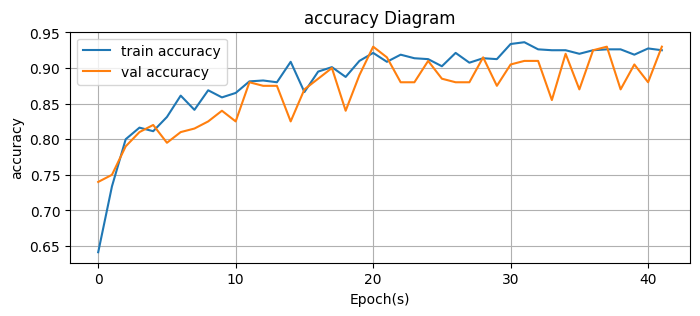

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.legend(['train accuracy', 'val accuracy'])
plt.title('accuracy Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('accuracy')
plt.grid(True)
plt.show()

7/7 [==============================] - 21s 3s/step


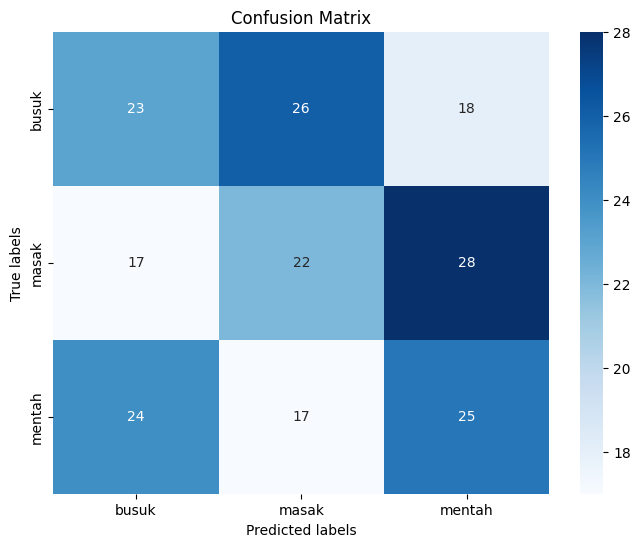

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Prediksi kelas gambar pada validation data
y_pred = model.predict(valid_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# True classes dari validation data
true_classes = valid_data.classes

# Nama kelas
class_names = list(valid_data.class_indices.keys())

# Membuat Confusion Matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Simpan Model

In [ ]:
# save model
model.save('/content/drive/MyDrive/Skripsi/model/myModel2(original_es_inceptionv3).h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

path_model_save = '/content/drive/MyDrive/Skripsi/model/myModel2(original_es_inceptionv3).h5'
loaded_model = load_model(path_model_save)

## Load Model dan Jalankan Model

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  img_path = '/content/' + fn
  img = image.load_img(img_path, target_size=(224, 224));
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  classes = loaded_model.predict(img_array/255);

  for i, class_ in enumerate(classes[0]):
      if class_ == classes[0].max():
          if i == 0:
              print("Pisang Busuk")
          elif i == 1:
              print("Pisang Masak")
          else:
              print("Pisang Mentah")

Saving 00000001 - Copy.jpg to 00000001 - Copy.jpg
Saving 00000003 - Copy.jpg to 00000003 - Copy.jpg
Saving 00000004 - Copy.jpg to 00000004 - Copy.jpg
Saving 00000007 - Copy.jpg to 00000007 - Copy.jpg
Saving 11.jpg to 11.jpg
Saving 00000014 - Copy.jpg to 00000014 - Copy.jpg
Saving 00000020.jpg to 00000020.jpg
Saving 00000044.jpg to 00000044.jpg
Saving 00000045.jpg to 00000045.jpg
Saving 61.jpg to 61.jpg
Saving 62.jpg to 62.jpg
Saving 63.jpg to 63.jpg
Saving 64.jpg to 64.jpg
Saving 65.jpg to 65.jpg
Saving 66.jpg to 66.jpg
Saving 67.jpg to 67.jpg
Saving download (1).jpg to download (1).jpg
Saving download (2).jpg to download (2).jpg
Saving download (4).jpg to download (4).jpg
Saving download.jpg to download.jpg
Saving images (2).jpg to images (2).jpg
Saving images (14).jpg to images (14).jpg
Saving images (16).jpg to images (16).jpg
Saving images (21).jpg to images (21).jpg
Saving images (45).jpg to images (45).jpg
Saving images (46).jpg to images (46).jpg
Saving images (48).jpg to images